In [1]:
import ee
import folium
import pandas as pd

In [2]:
# The first time to authenticate with your Google account
#ee.Authenticate()
# Initialize Earth Engine
ee.Initialize()

**We've loaded the boundaries for the parks we're interested in, but first let's explore how the park names are expressed in the collection.**

In [3]:
nps = ee.FeatureCollection('WCMC/WDPA/202006/polygons')

In [4]:
#Here I view how it's stored the name of the parks.
propertyN=nps.first().propertyNames().getInfo()
print(propertyN)

['WDPAID', 'REP_AREA', 'OWN_TYPE', 'REP_M_AREA', 'INT_CRIT', 'GOV_TYPE', 'ISO3', 'GIS_AREA', 'DESIG', 'STATUS', 'NO_TAKE', 'PA_DEF', 'WDPA_PID', 'MARINE', 'GIS_M_AREA', 'ORIG_NAME', 'DESIG_ENG', 'MANG_PLAN', 'NAME', 'DESIG_TYPE', 'METADATAID', 'MANG_AUTH', 'STATUS_YR', 'PARENT_ISO', 'NO_TK_AREA', 'VERIF', 'IUCN_CAT', 'SUB_LOC', 'system:index']


In [5]:
#Take the property (NAME) and retrun a list
names = nps.aggregate_array('NAME').getInfo()
#rep_area=nps.aggregate_array('REP_AREA').getInfo()
#rep_m_area=nps.aggregate_array('REP_M_AREA').getInfo()
gov_type=nps.aggregate_array('GOV_TYPE').getInfo()
#mang_auth=nps.aggregate_array('MANG_AUTH').getInfo()

In [6]:
#Print the list
print(names[:10])


['Comunidade de Montes Veciñais en Man Común de Santiago de Covelo', 'Comunidade do Monte Veciñal en Man Común de Froxán', 'Parque Natural Municipal Caixa D Água', 'Parque Natural Municipal De São Gonçalo', 'Parque Natural Municipal Do Manguezal De Itanguá', 'Parque Estadual Da Fonte Grande', 'Parque Natural Municipal Verde Vale', 'Parque Natural Municipal De Conceição Da Barra', 'Parque Natural Municipal Vale Do Mulembá', 'Parque Natural Municipal Do Tabuleiro']


In [7]:
#Here we explore others properties to see if it's possible to group parks by countries
gov_type_serie=pd.Series(gov_type)

In [8]:
gov_type_serie.unique()

array(['Local communities', 'Sub-national ministry or agency',
       'Federal or national ministry or agency', 'Not Reported',
       'Indigenous peoples', 'Collaborative governance',
       'Government-delegated management', 'Individual landowners',
       'Transboundary governance', 'Joint governance',
       'Non-profit organisations', 'For-profit organisations'],
      dtype=object)

In [9]:
#Now let's use pandas to search our national parks
names_serie=pd.Series(names)

In [10]:
# The string to search for the parks that interest us
search_string = 'voreca'

# Boolean indexing to find all occurrences containing the search string
results = names_serie[names_serie.str.contains(search_string)]

# Print the results
print('Occurrences of', search_string, 'in the series:', results)

Occurrences of voreca in the series: 218973    Cerro Chovoreca
dtype: object


**Now let's find the others mains parks in PY**: https://parquesnacionalesdelparaguay.blogspot.com/2012/07/mapa-de-las-areas-silvestres-protegidas.html

In [11]:
search_string_list=['fensores','danos','gripino','Cabrera','Negro', 'uazu','cyre','puku','guepey','hopi','rary']
for i in search_string_list:
    results = names_serie[names_serie.str.contains(i, na=False)]
    print('Occurrences of', i, 'in the series:', results)

Occurrences of fensores in the series: 218559    Defensores del Chaco
dtype: object
Occurrences of danos in the series: 188262                                Médanos de Samalayuca
214484                                      Medanos de Coro
216312    Ensenada de Rionegro, los Bajos Aledanos, las ...
218560                                    Medanos del Chaco
dtype: object
Occurrences of gripino in the series: 218549    Teniente Agripino Enciso
dtype: object
Occurrences of Cabrera in the series: 3634                       Sierra de la Cabrera - ZEPA
3706                              Sierra de la Cabrera
5331                           Sierra De Cabrera-Bedar
5696                           Sierra de Cabrera-Bédar
8840                           Archipielago De Cabrera
8932                           Archipielago De Cabrera
9173      Espacio marino del sur de Mallorca y Cabrera
9221                              Arxipèlag de Cabrera
218967                          Cerro Cabrera - Timane
dtype:

In [12]:
#The parks of interes has the next name in the dataset: 
#Cerro Chovoreca, Defensores del Chaco, Medanos del Chaco, Teniente Agripino Enciso, Cerro Cabrera - Timane, Rionegro, 
# Ñu Guazu, Reserva Biológica Isla Yacyreta, Bosque Arary

**There are two pairs with the same names (Rio Negro and Ñu Guasu), so let's see how we can differentiate them**

In [13]:
#We create a list with the duplicate words
duplicate_names = ['Rio Negro', 'Ñu Guazu', 'Medanos del Chaco', 'Defensores del Chaco']

filtered_features = nps.filter(ee.Filter.inList('NAME', duplicate_names))

# Convert filtered features to a list
features = filtered_features.toList(filtered_features.size())

# Extract properties for each filtered feature
def extract_properties(feature):
    feature = ee.Feature(feature)  # Cast to Feature
    properties = feature.toDictionary()  # Get all properties
    properties = properties.set('Park Name', feature.get('NAME'))  # Add 'Park Name' explicitly
    return properties

# Map the function to extract properties for the filtered features
properties_list = features.map(lambda f: extract_properties(f)).getInfo()

# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(properties_list)

In [14]:
# The parks of interest are the largest parks in PRY territory. So we are interested in parks with index 2 and 3
df

,DESIG,DESIG_ENG,DESIG_TYPE,GIS_AREA,GIS_M_AREA,GOV_TYPE,INT_CRIT,ISO3,IUCN_CAT,MANG_AUTH,...,PA_DEF,Park Name,REP_AREA,REP_M_AREA,STATUS,STATUS_YR,SUB_LOC,VERIF,WDPAID,WDPA_PID
0,"Ramsar Site, Wetland of International Importance","Ramsar Site, Wetland of International Importance",International,120284.651178,0,Federal or national ministry or agency,(i)(ii)(iii)(iv)(vii)(viii),BRA,VI,Not Reported,...,1,Rio Negro,120016.144,0,Designated,2018,BR-AM,State Verified,555637330,555637330
1,Reserva de Recursos Manejados - Privado,Managed Resource Reserve,National,2.900834,0,Not Reported,Not Applicable,PRY,VI,Not Reported,...,1,Ñu Guazu,2.800,0,Designated,2006,PY-11,State Verified,555629395,555629395
2,Parque Nacional - Publico,National Park,National,7242.355026,0,Not Reported,Not Applicable,PRY,II,Not Reported,...,1,Defensores del Chaco,7207.230,0,Designated,1975,PY-17,State Verified,242,242
3,Parque Nacional - Publico,National Park,National,6082.351686,0,Not Reported,Not Applicable,PRY,II,Not Reported,...,1,Medanos del Chaco,5142.330,0,Designated,2004,PY-16;PY-17,State Verified,61554,61554
4,Parque Nacional - Publico,National Park,National,1273.443656,0,Not Reported,Not Applicable,PRY,II,Not Reported,...,1,Rio Negro,1237.860,0,Designated,2004,PY-17,State Verified,61556,61556
5,Reserva Natural - Privado,Natural Private Reserve,National,498.314601,0,Not Reported,Not Applicable,PRY,IV,Not Reported,...,1,Ñu Guazu,500.000,0,Designated,2004,PY-16,State Verified,555629439,555629439


**Now let's import the images and features**

In [15]:
# Get MODIS 250m vegetation data.
mod13 = ee.ImageCollection('MODIS/061/MOD13Q1')

# Get the features of forest national parks and filter them by SUB_LOC 
# (the parks are located near the PY-16 and PY-17 routes)
rep_area=['PY-17', 'PY-16','PY-16;PY-17']
nps = (
    ee.FeatureCollection('WCMC/WDPA/202006/polygons')
    .filter(ee.Filter.inList('SUB_LOC', rep_area))
    .filter(ee.Filter.inList('NAME', ['Cerro Chovoreca','Defensores del Chaco','Medanos del Chaco', 'Teniente Agripino Enciso', 'Cerro Cabrera - Timane', 'Rio Negro','Ñu Guazu']))
    
)

**Compute annual summertime composites**

Build an image collection with an image for each year from 2000 to 2019. Each of these images is calculated to be the maximum EVI in the summer months of its corresponding year. This is our measure of the status of the vegetation for each year. Also add the year as a band, in preparation for linear trend analysis.

In [16]:
#Filter MODIS images to summer months between Dec and Feb 2000-2019,
#Add observation year as an image property.
mod13_summer = (
    mod13.filter(ee.Filter.calendarRange(12, 2, 'month'))
    .filter(ee.Filter.calendarRange(2000, 2019, 'year'))
    .map(lambda img: img.set('year', img.date().get('year')))
)

In [17]:
# Generate lists of images from the year using a join
join = ee.Join.saveAll('same_year')
condition = ee.Filter.equals(leftField='year', rightField='year')

mod13_summer_annual_join = join.apply(
    primary=mod13_summer.distinct('year'),
    secondary=mod13_summer,
    condition=condition
)

In [18]:
# Calculate annual max EVI composite images from the "same year" join lists
def calculate_summer_stats(img):
    year = img.get('year')
    year_col = ee.ImageCollection.fromImages(img.get('same_year'))
    max_evi = year_col.select('EVI').max()
    yr = ee.Image.constant(ee.Number(year)).toShort()
    return ee.Image.cat(yr, max_evi).rename(['year', 'max']).set('year', year)

summer_stats = ee.ImageCollection(mod13_summer_annual_join.map(calculate_summer_stats))

In [19]:
type(summer_stats)

ee.imagecollection.ImageCollection

**Estimate trends and infer vegetation condition**

Estimate a linear trend at each pixel by calculating its Sen's slope of maximum summer EVI with time. Calculate and visualize histograms of the regression slope values for each national park.

In [20]:
# Calculate time series slope using sensSlope()
sens = summer_stats.reduce(ee.Reducer.sensSlope())

In [21]:
# Function to calculate a histogram of slope values for a given geometry
def get_histogram(sens_img, geometry, title):
    # Calculate histogram as an ee.Array table
    hist = sens_img.select('slope').reduceRegion(
        reducer=ee.Reducer.autoHistogram(),
        geometry=geometry,
        scale=250,
        maxPixels=1e13
    )
    
    # Extract histogram array and bin/pixel count columns
    hist_array = ee.Array(hist.get('slope'))
    bin_bottom = hist_array.slice(1, 0, 1)
    n_pixels = hist_array.slice(1, 1, None)

    # Declare variables as global and then assign values
    global bin_bottom_list
    global n_pixels_list
    # Convert arrays to Python lists for charting or visualization (if needed)
    bin_bottom_list = bin_bottom.getInfo()
    n_pixels_list = n_pixels.getInfo()
    
    # Print the histogram data
    print(f"Histogram for {title}:")
    print("Bin Bottom:", bin_bottom_list)
    print("Pixel Count:", n_pixels_list)

**Plot the information**

In [22]:
# Get the slope histogram for specific geometries (parks)
chovoreca_geometry = nps.filter(ee.Filter.eq('NAME', 'Cerro Chovoreca')).geometry()
defensores_geometry = nps.filter(ee.Filter.eq('NAME', 'Defensores del Chaco')).geometry()


In [23]:
import matplotlib.pyplot as plt

In [24]:
# Define the function for the plot
def plot_histogram(bin_bottom, n_pixels, title):
    plt.figure(figsize=(12, 6))
    plt.plot(bin_bottom, n_pixels, color='green', linestyle='-', linewidth=1.5)
    plt.title(f"{title} Forest Condition Trend Histogram", fontsize=14)
    plt.xlabel('Slope',fontsize=12)
    plt.ylabel('Pixel Count',fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

Histogram for Cerro Chovoreca:
Bin Bottom: [[-79], [-78], [-77], [-76], [-75], [-74], [-73], [-72], [-71], [-70], [-69], [-68], [-67], [-66], [-65], [-64], [-63], [-62], [-61], [-60], [-59], [-58], [-57], [-56], [-55], [-54], [-53], [-52], [-51], [-50], [-49], [-48], [-47], [-46], [-45], [-44], [-43], [-42], [-41], [-40], [-39], [-38], [-37], [-36], [-35], [-34], [-33], [-32], [-31], [-30], [-29], [-28], [-27], [-26], [-25], [-24], [-23], [-22], [-21], [-20], [-19], [-18], [-17], [-16], [-15], [-14], [-13], [-12], [-11], [-10], [-9], [-8], [-7], [-6], [-5], [-4], [-3], [-2], [-1], [0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [7

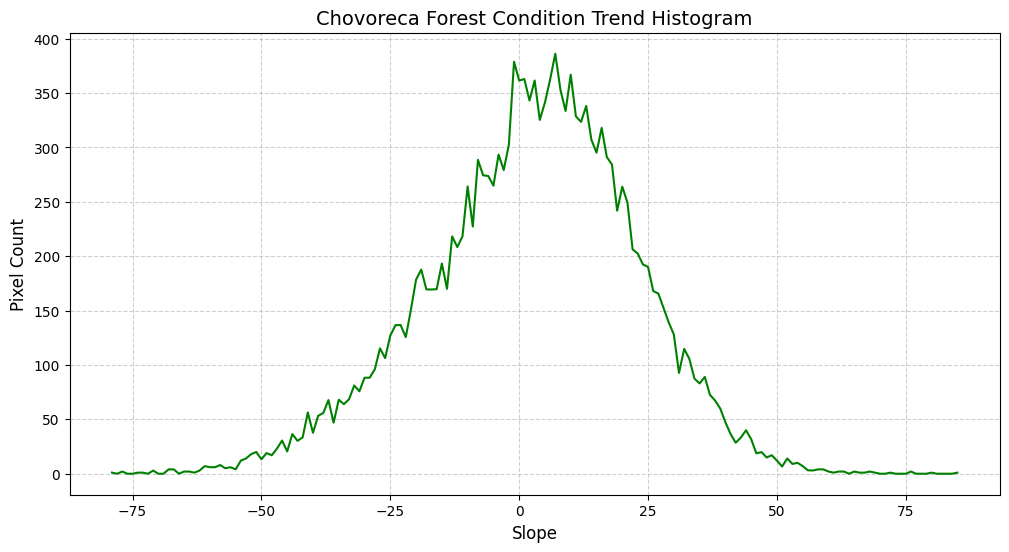

In [25]:
# Example usage for Chovoreca
get_histogram(sens, chovoreca_geometry, "Cerro Chovoreca") # Calculate and print histograms for the specified parks

bin_bottom_chovoreca = bin_bottom_list  # Replace with output from get_histogram
n_pixels_chovoreca = n_pixels_list
plot_histogram(bin_bottom_chovoreca, n_pixels_chovoreca, "Chovoreca")

Histogram for Defensores del Chaco:
Bin Bottom: [[-83], [-82], [-81], [-80], [-79], [-78], [-77], [-76], [-75], [-74], [-73], [-72], [-71], [-70], [-69], [-68], [-67], [-66], [-65], [-64], [-63], [-62], [-61], [-60], [-59], [-58], [-57], [-56], [-55], [-54], [-53], [-52], [-51], [-50], [-49], [-48], [-47], [-46], [-45], [-44], [-43], [-42], [-41], [-40], [-39], [-38], [-37], [-36], [-35], [-34], [-33], [-32], [-31], [-30], [-29], [-28], [-27], [-26], [-25], [-24], [-23], [-22], [-21], [-20], [-19], [-18], [-17], [-16], [-15], [-14], [-13], [-12], [-11], [-10], [-9], [-8], [-7], [-6], [-5], [-4], [-3], [-2], [-1], [0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64],

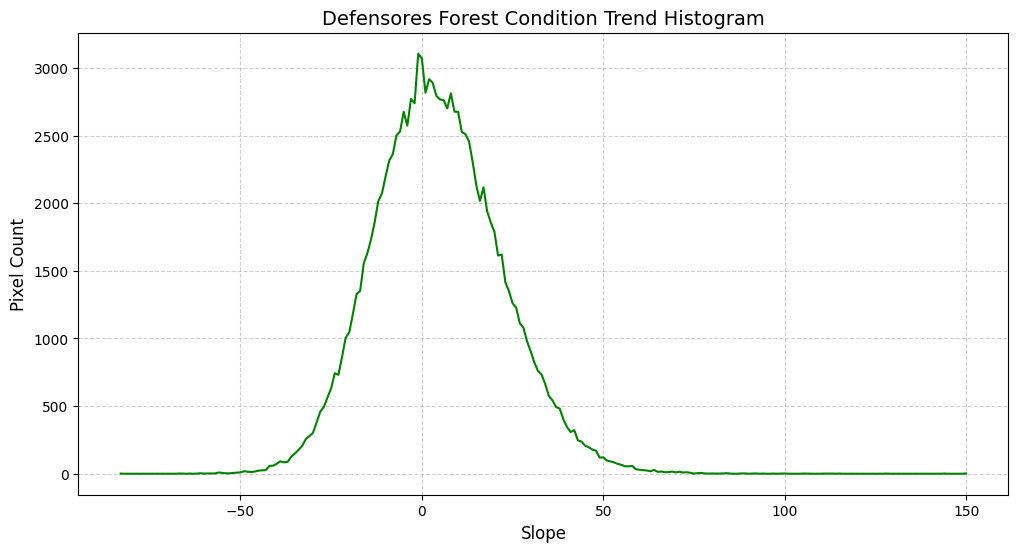

In [26]:
# Example usage for Defensores del Chaco
get_histogram(sens, defensores_geometry, "Defensores del Chaco") # Calculate and print histograms for the specified parks

bin_bottom_chovoreca = bin_bottom_list  # Replace with output from get_histogram
n_pixels_chovoreca = n_pixels_list
plot_histogram(bin_bottom_chovoreca, n_pixels_chovoreca, "Defensores")

**Infer pixel-wise vegetation greening or browning based on the sign of the slope value. Calculate summary of areas under greening and browning for each national park.**

In [27]:
#Infer pixel-wise vegetation condition based on sign of the slope.
cond = ee.Image.cat(sens.select('slope').gt(0).rename('greening'),
                    sens.select('slope').lt(0).rename('browning'))

#Calculate area under greening and browning in each national park.
npsRes = cond.multiply(ee.Image.pixelArea()).reduceRegions(nps, ee.Reducer.sum(), 250)

**Visualise results**

In [28]:
# Function to format results of greening and browning
def format_results(feature):
    browning_sq_m = feature.getNumber('browning')
    greening_sq_m = feature.getNumber('greening')
    forest_sq_m = feature.area()
    
    return feature.set({
        'Browning sq km': browning_sq_m.divide(1e6),
        'Browning fraction': browning_sq_m.divide(forest_sq_m),
        'Greening sq km': greening_sq_m.divide(1e6),
        'Greening fraction': greening_sq_m.divide(forest_sq_m),
    })

# Apply the formatting function to the feature collection
nps_res_formatted = npsRes.map(format_results)

# Convert the feature collection to a table for export or analysis
def extract_properties(feature):
    return {
        'NAME': feature.get('NAME'),
        'Browning sq km': feature.get('Browning sq km'),
        'Browning fraction': feature.get('Browning fraction'),
        'Greening sq km': feature.get('Greening sq km'),
        'Greening fraction': feature.get('Greening fraction'),
    }

In [29]:
# Extract properties from all features
formatted_results = nps_res_formatted.map(lambda feature: ee.Feature(None, extract_properties(feature)))

# Convert to a Pandas DataFrame for tabular display
features = formatted_results.getInfo()['features']
rows = [feat['properties'] for feat in features]
df = pd.DataFrame(rows)
df

,Browning fraction,Browning sq km,Greening fraction,Greening sq km,NAME
0,0.232595,92.055354,0.764460,302.554295,Teniente Agripino Enciso
1,0.400265,2892.214631,0.595640,4303.944056,Defensores del Chaco
2,0.373891,2269.697968,0.622631,3779.671345,Medanos del Chaco
3,0.302022,383.749064,0.694288,882.162258,Rio Negro
4,0.195410,237.265667,0.800257,971.665059,Cerro Cabrera - Timane
5,0.411959,406.347626,0.583515,575.566496,Cerro Chovoreca
6,0.465645,231.518041,0.530332,263.680442,Ñu Guazu


**Choose suitable visualization parameters and display the slope values on the map to denote areas under greening and browning, along with the national park boundaries.**

In [30]:
import geemap
geemap.ee_initialize()

In [31]:
center_point = nps.geometry().centroid().getInfo()['coordinates']  # Get center coordinates
zoom_level = 10  # Zoom level (adjust as needed)

# Visualization parameters
vis_params = {
    'opacity': 1,
    'bands': ['slope'],
    'min': -55,
    'max': 55,
    'palette': ['8c510a', 'd8b365', 'f6e8c3', 'f5f5f5', 'd9f0d3', '7fbf7b', '1b7837']
}

# Prepare Sen's slope visualization
clipped_sens = sens.clipToCollection(nps)

# Display national park boundaries
paimg = ee.Image().byte().paint(nps, 0, 2)

In [32]:
# Create a map object
map = geemap.Map(center=center_point[::-1], zoom=zoom_level)  # Folium uses lat, lon format

# Add layers to the map
map.addLayer(clipped_sens, vis_params, "Sen's slope")
map.addLayer(paimg, {'palette': '000000'}, 'National Parks')

# Display the map
map

Map(center=[-20.186360341227903, -60.6765434570433], controls=(WidgetControl(options=['position', 'transparent…

In [33]:
# Save the map to an HTML file
#name="example.html"
#map.save(name)

**Trend Analysis. Chart the median of maximum summer EVIs in each national park over the years.**


In [35]:

def compute_trend_by_year():
    def compute_yearly_trend(image):
        year = image.get('year')  # Extract the year from the image properties
        stats = image.reduceRegions(
            collection=nps,
            reducer=ee.Reducer.median(),
            scale=250
        )
        # Add the year property to each feature
        return stats.map(lambda f: f.set('year', year))
    
    # Map over the ImageCollection (one image per year)
    yearly_trend = summer_stats.map(compute_yearly_trend).flatten()
    return yearly_trend

In [36]:
trend_fc = compute_trend_by_year().getInfo()  # Fetch the results

In [37]:
# Parse and organize data
region_data = {}
for feature in trend_fc['features']:
    region_name = feature['properties']['NAME']
    year = feature['properties']['year']
    value = feature['properties']['max']

    # Initialize region if not already present
    if region_name not in region_data:
        region_data[region_name] = {'years': [], 'values': []}
    
    # Append year and value
    region_data[region_name]['years'].append(year)
    region_data[region_name]['values'].append(value)


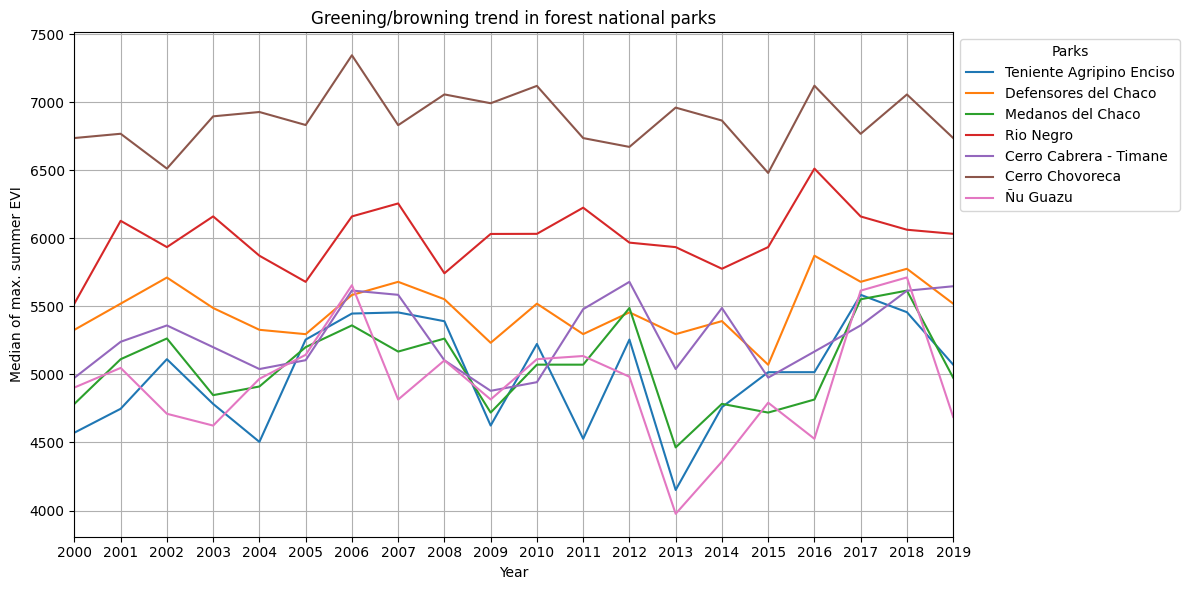

<Figure size 640x480 with 0 Axes>

In [48]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot for each region
for region_name, data in region_data.items():
    plt.plot(data['years'], data['values'], label=region_name)

# Customize the plot
plt.title("Greening/browning trend in forest national parks")
plt.xlabel("Year")
plt.ylabel("Median of max. summer EVI")
plt.legend(title="Parks", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Adjust x-axis ticks to show only integer years from 2000 to 2019
plt.xticks(ticks=range(2000, 2020), labels=range(2000, 2020))
plt.xlim(2000, 2019)

# Show the plot
plt.show()

# Save the plot
#plt.savefig('forest_national_parks_trend.png', dpi=300, bbox_inches='tight')